# **keras-tuner**


## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.5 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
from keras.layers import Dense, Conv2D, MaxPool2D, Conv1D, MaxPool1D, Normalization, Reshape,Flatten
from keras.models import Sequential
from keras.backend import clear_session
from keras.optimizers import Adam
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import kerastuner as kt

Using TensorFlow backend


<ipython-input-3-1ebe9b22baad>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(hist['loss'], marker = '.', label = 'train_acc')
    plt.plot(hist['val_loss'], marker = '.', label = 'val_acc')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터셋 : Auto MPG

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
data = raw_dataset.copy()
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 2.데이터 전처리

### (1) 결측치 조치

In [ ]:
data.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

이 초기 튜토리얼을 간단하게 유지하려면 해당 행을 삭제하세요.

In [ ]:
data = data.dropna()

### (2) 가변수화

In [ ]:
data['Origin'] = data['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

<ipython-input-9-8e17076f6c07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Origin'] = data['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})


In [ ]:
data = pd.get_dummies(data, columns=['Origin'], prefix='', prefix_sep='')
data.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### (3) 데이터셋 분할

In [ ]:
train = data.sample(frac=0.8, random_state=0)
test = data.drop(train.index)

전체 통계도 확인해보겠습니다. 각 특성이 매우 다른 범위를 포괄하고 있는 것에 주목하세요.

In [ ]:
x_train = train.copy()
x_test = test.copy()

y_train = x_train.pop('MPG')
y_test = x_test.pop('MPG')

### (4) 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## 3.모델링1 : base line

선형회귀 모델

In [ ]:
clear_session()
model1 = Sequential([Dense(1, input_shape = (x_train.shape[1],))])

model1.compile(loss='mean_absolute_error', optimizer=Adam(0.1))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 10        
                                                                 
Total params: 10 (40.00 Byte)
Trainable params: 10 (40.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
%%time
hist = model1.fit(x_train, y_train, validation_split=0.2, verbose=0, epochs=100).history

CPU times: user 7.71 s, sys: 220 ms, total: 7.93 s
Wall time: 22 s


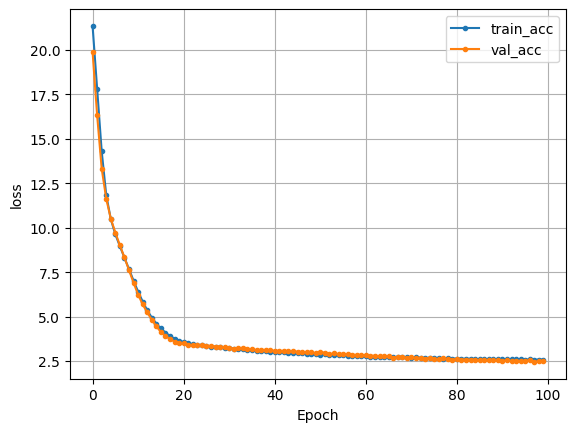

In [ ]:
dl_history_plot(hist)

MAE : 2.3738650762117826


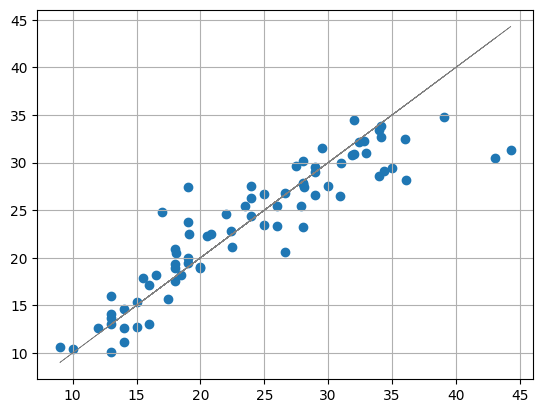

In [ ]:
pred1 = model1.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred1))

plt.scatter(y_test, pred1)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()

## 4.모델링2 : hyperparameter tuning

keras tuner활용

### (1) hidden layer 1개 노드 튜닝
* 튜닝 방식 : RandomSearch
* 실험 : 총 10회
    * 노드 : 8, 16, 32, 64, 128, 256
    * 학습률 : 0.0001, 0.001, 0.01

In [ ]:
def build_model(hp):
    model = Sequential([ Dense(units=hp.Choice('node1', [8, 16, 32, 64, 128, 256]),
                               input_shape = (x_train.shape[1],), activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate = hp.Choice('learning_rate', [0.0001, 0.001, 0.01])))
    return model

In [ ]:
%%time
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials = 10, project_name='dnn_tune_2')
tuner.search(x_train, y_train, epochs = 100, validation_split = .2, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

Results summary
Results in ./dnn_tune_2
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
node1: 32
learning_rate: 0.001


In [ ]:
# 튜닝 모델을 이용하여 예측하고 평가하기
pred2_1 = best_model.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred2_1))

plt.scatter(y_test, pred2_1)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()

NameError: ignored

### (2) hidden layer 2개 노드 튜닝
* 튜닝 방식 : GridSearch
* 실험 : 총 15회
    * 노드1 : 16, 32, 64, 128, 256
    * 노드2 : 8, 16, 32, 64,128
    * 학습률 : 0.0001, 0.001, 0.01

In [ ]:
def build_model(hp):
    n1 = hp.Choice('node1', [16, 32, 64, 128, 256])
    model = Sequential([ Dense(units=n1,
                               input_shape = (x_train.shape[1],), activation='relu'),
                         Dense(units=n1,
                               activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate = 0.001))
    return model

In [ ]:
%%time
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials = 2, project_name='dnn_tune_3')
tuner.search(x_train, y_train, epochs = 30, validation_split = .2, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

CPU times: user 6.69 s, sys: 223 ms, total: 6.92 s
Wall time: 7.37 s


In [ ]:
tuner.results_summary()

Results summary
Results in ./dnn_tune_3
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0 summary
Hyperparameters:
node1: 256
Score: 2.2888436317443848

Trial 1 summary
Hyperparameters:
node1: 32
Score: 4.071742534637451


MAE : 1.8656861329690007


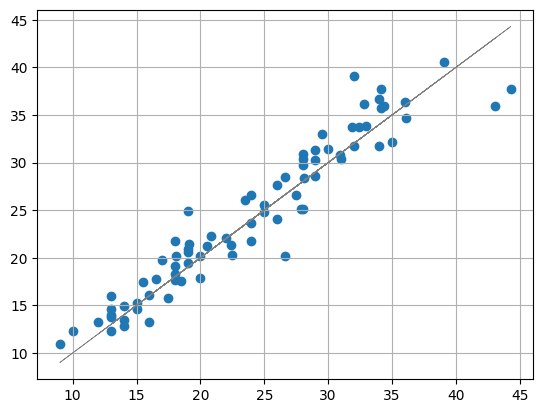

In [ ]:
pred2_2 = best_model.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred2_2))

plt.scatter(y_test, pred2_2)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()

### (3) hidden layer 3개 노드 튜닝
* 튜닝 방식 : GridSearch
* 실험 : 총 20회
    * 노드1 : 16, 32, 64, 128, 256
    * 노드2 : 8, 16, 32, 64,128
    * 노드3 : 4, 8, 16, 32, 64
    * 학습률 : 0.0001, 0.001, 0.01

In [ ]:
def build_model(hp):
    model = Sequential([ Dense(units=hp.Choice('node1', [16, 32, 64, 128, 256]), input_shape = (x_train.shape[1],), activation='relu'),
                         Dense(units=hp.Choice('node2', [8, 12, 32, 64, 128]), activation='relu'),
                         Dense(units=hp.Choice('node3', [4, 8, 12, 32, 64]), activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate = hp.Choice('learning_rate', [0.0001, 0.001, 0.01])))
    return model

In [ ]:
%%time
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials = 20, project_name='dnn_tune_4')
tuner.search(x_train, y_train, epochs = 100, validation_split = .2, verbose=0)
best_model = tuner.get_best_models(num_models=1)[0]

CPU times: user 2min 27s, sys: 4.72 s, total: 2min 32s
Wall time: 3min 7s


In [ ]:
tuner.results_summary()

Results summary
Results in ./dnn_tune3
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 02 summary
Hyperparameters:
node1: 96
node2: 40
node3: 32
Score: 1.9995839595794678

Trial 01 summary
Hyperparameters:
node1: 48
node2: 40
node3: 28
Score: 2.013288974761963

Trial 04 summary
Hyperparameters:
node1: 128
node2: 56
node3: 24
Score: 2.0166640281677246

Trial 00 summary
Hyperparameters:
node1: 64
node2: 40
node3: 8
Score: 2.0227162837982178

Trial 06 summary
Hyperparameters:
node1: 128
node2: 64
node3: 8
Score: 2.024810552597046

Trial 12 summary
Hyperparameters:
node1: 112
node2: 48
node3: 4
Score: 2.031716823577881

Trial 16 summary
Hyperparameters:
node1: 128
node2: 48
node3: 4
Score: 2.033858060836792

Trial 17 summary
Hyperparameters:
node1: 112
node2: 24
node3: 16
Score: 2.0383574962615967

Trial 18 summary
Hyperparameters:
node1: 112
node2: 64
node3: 16
Score: 2.0387134552001953

Trial 10 summary
Hyperparameters:
node1: 96
node2: 64
node3: 20
Score: 2.042

MAE : 1.8213926193041676


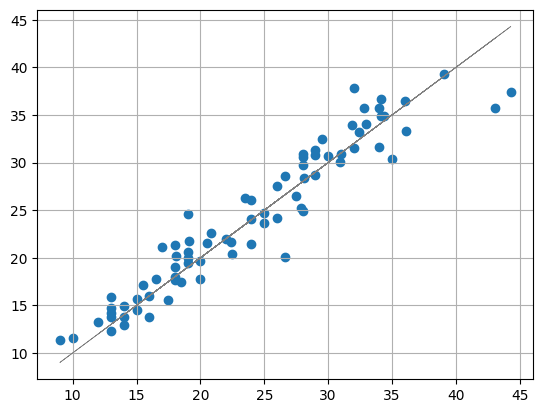

In [ ]:
pred2_3 = best_model.predict(x_test, verbose = 0)
print('MAE :', mean_absolute_error(y_test, pred2_3))

plt.scatter(y_test, pred2_3)
plt.plot(y_test, y_test, color = 'gray', linewidth = .5)
plt.grid()
plt.show()